# Google Colab Notebook for Running Inference on MedSAM

In [ ]:
!pip install -q git+https://github.com/bowang-lab/MedSAM.git
!pip install monai

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.6 MB/s eta 0:00:00


In [ ]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
import nibabel as nib
from monai.metrics import compute_hausdorff_distance

# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


In [ ]:
from ipywidgets import interact, IntSlider
from matplotlib.colors import ListedColormap

def visualize_scan(img_arr, label_arr, axis):
  @interact(slice_index=IntSlider(min=0, max=img_arr.shape[axis]-1, step=1, value=0))
  def plot_slice(slice_index):
    plt.figure(figsize=(6, 6))
    plt.imshow(np.take(img_arr, slice_index, axis=axis), cmap='gray')
    if label_arr is not None:
      plt.imshow(np.take(label_arr, slice_index, axis=axis), cmap=ListedColormap(['None', 'green']),
                vmin=0, vmax=1, alpha=0.4)
    plt.title(f'Slice {slice_index}')
    plt.axis('off')
    plt.show()

In [ ]:
# download model and data
!wget -O img_demo.png https://raw.githubusercontent.com/bowang-lab/MedSAM/main/assets/img_demo.png
!wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

In [ ]:
#%% load model and image
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

img_np = io.imread('img_demo.png')
if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np
H, W, _ = img_3c.shape

In [ ]:
#%% image preprocessing and model inference
img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

box_np = np.array([[95,255, 190, 350]])
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

NameError: name 'img_3c' is not defined

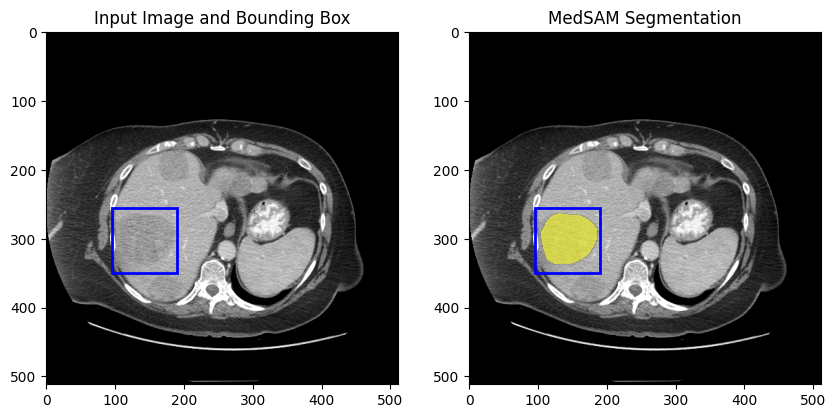

In [ ]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()

# Segmenting UCLA Kidney CT

## Converting Segmentation to Bounding Box

In [ ]:
# Importing sample data
from google.colab import drive
drive.mount(r'/content/drive')

Mounted at /content/drive


In [ ]:
# is_kits_data = False
# kid_img = nib.load('/content/drive/MyDrive/Colab Notebooks/Dataset248_UCLA_sample_kidney/0003_0000.nii.gz').get_fdata()
# kid_label_nib = nib.load('/content/drive/MyDrive/Colab Notebooks/Dataset248_UCLA_sample_kidney/0003.nii.gz')
# kid_label = kid_label_nib.get_fdata()

In [ ]:
is_kits_data = True
kid_img = nib.load('/content/drive/MyDrive/Colab Notebooks/Dataset220_KiTS2023_sample_kidney/case_00000_0000.nii.gz').get_fdata()
kid_label_nib = nib.load('/content/drive/MyDrive/Colab Notebooks/Dataset220_KiTS2023_sample_kidney/case_00000.nii.gz')
kid_label = kid_label_nib.get_fdata()

# Mask label to only 0=background and 1=lesion
kid_label[kid_label != 2] = 0
kid_label[kid_label == 2] = 1

# Rearrange img and label into H, W, C
kid_img = kid_img.transpose((1, 2, 0))
kid_label = kid_label.transpose((1, 2, 0))

In [ ]:
# lesion slices
np.unique(np.where(kid_label == 1)[2])

array([289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,
       302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314,
       315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327,
       328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340,
       341, 342, 343])

In [ ]:
# prompt: kid_label is a binary mask where 0 is the background and 1 is a lesion. The shape is of (512,512,175). For each slice across the dimension that is of size 175, make a bounding box that encapsulates the mask

import matplotlib.pyplot as plt
import numpy as np
def get_bounding_box(mask_slice):
    """
    Calculates the bounding box coordinates for a binary mask slice.

    Args:
        mask_slice (np.ndarray): A 2D numpy array representing a single slice
                                 of the binary mask (0 for background, 1 for lesion).

    Returns:
        tuple: A tuple containing the bounding box coordinates (x_min, y_min, x_max, y_max),
               or None if no lesion is present in the slice.
    """
    rows = np.any(mask_slice, axis=1)
    cols = np.any(mask_slice, axis=0)
    y_min, y_max = np.where(rows)[0][[0, -1]] if np.any(rows) else (None, None)
    x_min, x_max = np.where(cols)[0][[0, -1]] if np.any(cols) else (None, None)

    if x_min is not None and y_min is not None:
        return np.array([x_min, y_min, x_max, y_max])
    else:
        return None

# Iterate through each slice of the kid_label and find the bounding box
bounding_boxes = []
for i in range(kid_label.shape[2]):
    slice_mask = kid_label[:, :, i]
    bbox = get_bounding_box(slice_mask)
    bounding_boxes.append(bbox)

# You can now access the bounding box for each slice in the bounding_boxes list.
# For example, to see the bounding box for the first slice:
# print(bounding_boxes[0])

# To visualize the bounding boxes on slices (optional)
def visualize_scan_with_bbox(img_arr, label_arr, axis, bounding_boxes):
  @interact(slice_index=IntSlider(min=0, max=img_arr.shape[axis]-1, step=1, value=0))
  def plot_slice(slice_index):
    plt.figure(figsize=(6, 6))
    plt.imshow(np.take(img_arr, slice_index, axis=axis), cmap='gray')
    if label_arr is not None:
      plt.imshow(np.take(label_arr, slice_index, axis=axis), cmap=ListedColormap(['None', 'green']),
                vmin=0, vmax=1, alpha=0.4)
    bbox = bounding_boxes[slice_index]
    if bbox is not None:
        show_box(np.array(bbox), plt.gca())
    plt.title(f'Slice {slice_index}')
    plt.axis('off')
    plt.show()

# Call the visualization function with bounding boxes
visualize_scan_with_bbox(kid_img, kid_label, axis=2, bounding_boxes=bounding_boxes)

interactive(children=(IntSlider(value=0, description='slice_index', max=610), Output()), _dom_classes=('widget…

## Preprocessing Image

In [ ]:
H, W, C = kid_img.shape

In [ ]:
# Clipping
img_1024 = np.clip(kid_img, -160, 240)
# Min-Max normalization
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# Resize
img_1024 = transform.resize(img_1024, (1024, 1024, C), order=3, preserve_range=True, anti_aliasing=True)

## Predictions

In [ ]:
!wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth

--2025-05-30 07:43:39--  https://zenodo.org/records/10689643/files/medsam_vit_b.pth
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375049145 (358M) [application/octet-stream]
Saving to: ‘medsam_vit_b.pth’

medsam_vit_b.pth    100%[===================>] 357.67M  4.37MB/s    in 1m 58s  

2025-05-30 07:45:38 (3.02 MB/s) - ‘medsam_vit_b.pth’ saved [375049145/375049145]



In [ ]:
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [ ]:
lesion_channel_idx = np.unique(np.where(kid_label == 1)[2]).astype(int)

In [ ]:
kid_pred = np.zeros(kid_label.shape)
for c in lesion_channel_idx:
  img_slice = img_1024[:, :, c]
  slice_tensor = torch.tensor(img_slice).unsqueeze(0).repeat(3, 1, 1).unsqueeze(0).to(device)
  # Bounding box
  box_np = get_bounding_box(kid_label[:,:,c])
  box_np = np.expand_dims(box_np, axis=0)
  box_1024 = box_np / np.array([W, H, W, H]) * 1024
  with torch.no_grad():
    image_embedding = medsam_model.image_encoder(slice_tensor.float()) # (1, 256, 64, 64)
  medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
  kid_pred[:,:,c] = medsam_seg

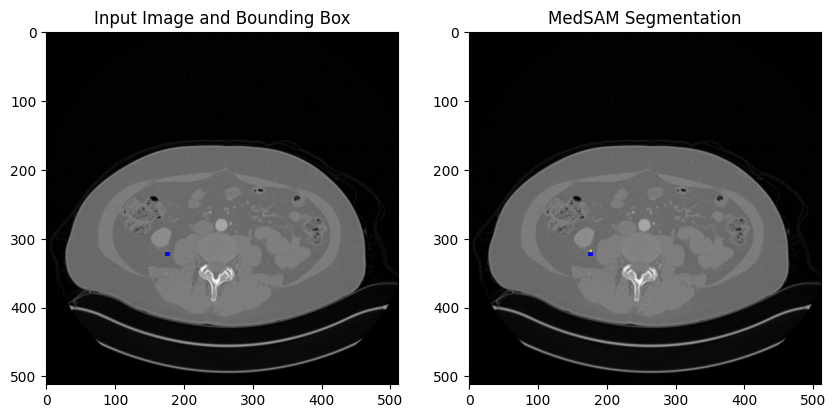

In [ ]:
#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(kid_img[:,:,c], cmap='gray')
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(kid_img[:,:,c], cmap='gray')
show_mask(kid_pred[:,:,c], ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()

In [ ]:
visualize_scan_with_bbox(kid_img, kid_label, axis=2, bounding_boxes=bounding_boxes)

interactive(children=(IntSlider(value=0, description='slice_index', max=610), Output()), _dom_classes=('widget…

In [ ]:
visualize_scan_with_bbox(kid_img, kid_pred, axis=2, bounding_boxes=bounding_boxes)

interactive(children=(IntSlider(value=0, description='slice_index', max=610), Output()), _dom_classes=('widget…

In [ ]:
# Evaluating dice score
intersection = np.sum(kid_label * kid_pred)
union = np.sum(kid_label) + np.sum(kid_pred)
eps = 1e-8
dice = (2.0 * intersection + eps) / (union + eps)
dice

np.float64(0.7724531328917162)

In [ ]:
og_shape = kid_label.shape
og_spacing = kid_label_nib.header.get_zooms()
if is_kits_data:
  # Changing og_spacing because rearranged axes earlier
  og_spacing = og_spacing[1:] + (og_spacing[0],)
new_shape = (1024, 1024, og_shape[2])
new_spacing = tuple(np.array(og_spacing) * np.array(og_shape) / np.array(new_shape))

In [ ]:
# Evaluating hausdorff distance

# one hot encode 3D tensor
kid_label_onehot = np.stack([(kid_label == 0).astype(int), (kid_label == 1).astype(int)], axis=0)
kid_label_onehot = np.expand_dims(kid_label_onehot, axis=0)

kid_pred_onehot = np.stack([(kid_pred == 0).astype(int), (kid_pred == 1).astype(int)], axis=0)
kid_pred_onehot = np.expand_dims(kid_pred_onehot, axis=0)
hd = compute_hausdorff_distance(kid_pred_onehot, kid_label_onehot, spacing=new_spacing)
hd

tensor([[4.9247]])

In [ ]:
hd.item()

4.924699306488037